In [29]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

video_path = '/content/drive/MyDrive/vision/senza_ombre_motog5.mp4'

# Find boxes
using frame difference and contours

In [20]:
cap = cv.VideoCapture(video_path)

In [26]:
cap.isOpened()

False

In [31]:
cap = cv.VideoCapture(video_path)
frames = []
processed = []
for i in range(200):
  ret, frame_current = cap.read()
  ret_next, frame_next = cap.read()
  if not ret or not ret_next:
    print('exiting')
    break
  gray_current = cv.cvtColor(frame_current, cv.COLOR_BGR2GRAY)
  gray_next = cv.cvtColor(frame_next, cv.COLOR_BGR2GRAY)

  mask = np.zeros_like(gray_current)
  mask[400:,:] = 1

  difference = cv.absdiff(gray_current, gray_next)

  blur = cv.GaussianBlur(difference,(5,5),0)
  ret, thresh = cv.threshold(difference, 30, 255, cv.THRESH_BINARY)
  thresh = cv.bitwise_and(thresh, mask, None)
  kernel = np.ones((3,3),np.uint8)
  dilated = cv.dilate(thresh,kernel,iterations = 1)

  frames.append(frame_current)
  processed.append(dilated)
cap.release()
  



In [66]:
mask = processed[119]
frame = frames[119]
contours, hierarchy = cv.findContours(mask,cv.RETR_TREE,cv.CHAIN_APPROX_NONE)
boxes = []
for c in contours:
    start_point = []
    end_points = []
    min = float('inf')
    max = 0
    contour_slim = c[:,0,:]
    for point in contour_slim:
      value = point[0] + point[1]
      if min > value:
        min = value
        start_point = point
      if max < value:
        max = value
        end_point = point
    start_point = (start_point[0], start_point[1])
    end_point = (end_point[0], end_point[1])
    boxes.append((start_point, end_point))
    # color = (255,0,0)
    # thickness = 2
    # # print(type(start_point))
    # col_images[frame] = cv2.rectangle(col_images[frame], start_point, end_point, color, thickness)
    # plt.imshow(image) 
  # break

In [67]:
size_max = 0
for box in boxes:
  size = abs(box[0][0] - box[1][0]) * abs(box[0][1] - box[1][1])
  if size > size_max:
    size_max = size
    max_box = box
    print('new max = ', box, size_max)
frame = cv.rectangle(frame, max_box[0], max_box[1], (0,255,0), 5)

new max =  ((1054, 680), (1062, 693)) 104
new max =  ((1077, 583), (1167, 696)) 10170


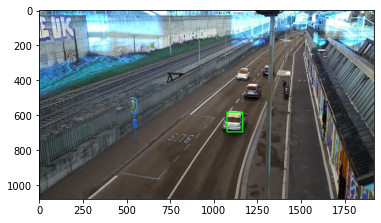

In [68]:
plt.imshow(frame)

In [69]:
max_box

((1077, 583), (1167, 696))

# Mean shift

In [70]:
track_window = (1077, 583, 100, 100)#max_box
processed_frames = []
for frame in frames[121:]:
  hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
  dst = cv.calcBackProject([hsv],[0],roi_hist,[0,180],1)
  # apply meanshift to get the new location
  ret, track_window = cv.meanShift(dst, track_window, term_crit)
  # Draw it on image
  x,y,w,h = track_window
  img2 = cv.rectangle(frame, (x,y), (x+w,y+h), 255,2)
  processed_frames.append(img2)

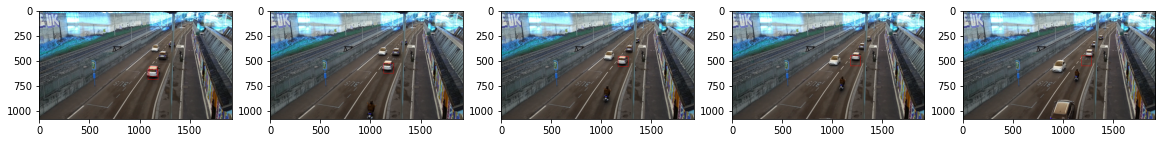

In [71]:
fig, ax = plt.subplots(1,5, figsize=(20,20))
ax[0].imshow(processed_frames[0])
ax[1].imshow(processed_frames[5])
ax[2].imshow(processed_frames[10])
ax[3].imshow(processed_frames[15])
ax[4].imshow(processed_frames[20])

same code as above, but for applying on a video

In [53]:
cap = cv.VideoCapture(video_path)
# take first frame of the video
ret,frame = cap.read()
# setup initial location of window
x, y, w, h = 308, 818, 100, 100
track_window = (x, y, w, h)
# set up the ROI for tracking
roi = frame[y:y+h, x:x+w]
hsv_roi =  cv.cvtColor(roi, cv.COLOR_BGR2HSV)
mask = cv.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.)))
roi_hist = cv.calcHist([hsv_roi],[0],mask,[180],[0,180])
cv.normalize(roi_hist,roi_hist,0,255,cv.NORM_MINMAX)
# Setup the termination criteria, either 10 iteration or move by atleast 1 pt
term_crit = ( cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 1 )
processed_frames = []
while(1):
    ret, frame = cap.read()
    if ret == True:
        hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
        dst = cv.calcBackProject([hsv],[0],roi_hist,[0,180],1)
        # apply meanshift to get the new location
        ret, track_window = cv.meanShift(dst, track_window, term_crit)
        # Draw it on image
        x,y,w,h = track_window
        img2 = cv.rectangle(frame, (x,y), (x+w,y+h), 255,2)
        processed_frames.append(img2)
    else:
        break

# Cam shift

In [91]:
cap = cv.VideoCapture(video_path)
# take first frame of the video
ret,frame = cap.read()
for i in range(100):
  ret,frame = cap.read()
# setup initial location of window
x, y, w, h = 1190, 280, 70, 70 # simply hardcoded the values
track_window = (x, y, w, h)
# set up the ROI for tracking
roi = frame[y:y+h, x:x+w]
hsv_roi =  cv.cvtColor(roi, cv.COLOR_BGR2HSV)
mask = cv.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.)))
roi_hist = cv.calcHist([hsv_roi],[0],mask,[180],[0,180])
cv.normalize(roi_hist,roi_hist,0,255,cv.NORM_MINMAX)
# Setup the termination criteria, either 10 iteration or move by atleast 1 pt
term_crit = ( cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 1 )

processed_frames = []
while(1):
    ret, frame = cap.read()
    if ret == True:
        hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
        dst = cv.calcBackProject([hsv],[0],roi_hist,[0,180],1)
        # apply camshift to get the new location
        ret, track_window = cv.CamShift(dst, track_window, term_crit)
        # Draw it on image
        pts = cv.boxPoints(ret)
        pts = np.int0(pts)
        img2 = cv.polylines(frame,[pts],True, 255,2)
        processed_frames.append(img2)
    else:
        break

we try to track this box

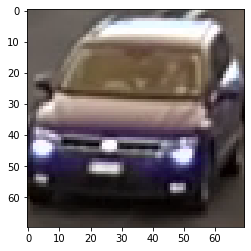

In [90]:
plt.imshow(processed_frames[0][280:350,1190:1260])

inspect result frames

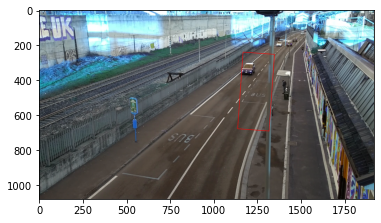

In [98]:
plt.imshow(processed_frames[10])

# Export result

In [97]:
out = cv.VideoWriter('/content/drive/MyDrive/vision/test.mp4',cv.VideoWriter_fourcc(*'DIVX'), 24, (1920,1080))

for i in range(len(processed_frames)):
    # writing to a image array
    out.write(processed_frames[i])
    if (i % 100 == 0):
      print('processed frame ', i)

out.release()

processed frame  0
processed frame  100
processed frame  200
processed frame  300
processed frame  400
processed frame  500
processed frame  600
processed frame  700
processed frame  800
processed frame  900
processed frame  1000


In [ ]:
from google.colab import files
files.download('/content/drive/MyDrive/vision/test.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>